* Anton Karazeev, you can text me: [```anton.karazeev@gmail.com```](mailto:anton.karazeev@phystech.edu) or [t.me/akarazeev](https://t.me/akarazeev)

Решение в последней ячейке

_

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
import gym

env = gym.make("Taxi-v2")
env.reset();

[2017-10-22 15:48:38,909] Making new env: Taxi-v2


In [165]:
# Display the game state
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [166]:
n_states = env.observation_space.n
n_actions = env.action_space.n

def get_random_policy():
    return np.random.randint(0, high=n_actions, size=n_states)

In [167]:
from itertools import count

def sample_reward(env, policy, t_max=100):
    s = env.reset()
    total_reward = 0
    
    action = policy[s]
    
    for t in count():
        new_obs, reward, is_done, _ = env.step(action)
        total_reward += reward
        
        action = policy[new_obs]
        
        if is_done or t > t_max:
            break
    
    return total_reward

In [168]:
def evaluate(policy, n_times=100):
    rewards = [sample_reward(env, policy) for _ in range(n_times)]
    return float(np.mean(rewards))

In [169]:
def crossover(policy1, policy2, p=0.5):
    """
    For each state, with probability `p` take action from `policy1`, else `policy2`.
    """
    new_policy = []
    for i in range(len(policy1)):
        eps = np.random.rand()
        if eps < p:
            new_policy.append(policy1[i])
        else:
            new_policy.append(policy2[i])
    return new_policy

In [170]:
def mutation(policy, p=0.1):
    """
    For each state, with probability `p` replace action with random action
    Tip: mutation can be written as crossover with random policy
    """
    return crossover(get_random_policy(), policy, p)

In [171]:
n_epochs = 10     # How many cycles to make
pool_size = 20     # How many policies to maintain
n_crossovers = 10  # How many crossovers to make on each step
n_mutations = 10   # How many mutations to make on each tick

print("initializing...")
pool = [get_random_policy() for _ in range(pool_size)]
pool_scores = [evaluate(policy) for policy in pool]

initializing...


In [172]:
for epoch in range(n_epochs):
    print("Epoch %s:" % epoch)
    
    crossovered = [crossover(pool[ind1], pool[ind2])
                   for (ind1, ind2) in [np.random.choice(np.arange(len(pool)), size=2, replace=False)
                                        for _ in range(n_crossovers)]]
    
    mutated = [mutation(pool[np.random.choice(np.arange(len(pool)))]) for _ in range(n_mutations)]
    
    assert type(crossovered) == type(mutated) == list
    
    # Add new policies to the pool
    pool.extend(crossovered)
    pool.extend(mutated)
    pool_scores = [evaluate(policy) for policy in pool]
    
    # Select `pool_size` best policies
    selected_indices = np.argsort(pool_scores)[-pool_size:]
    pool = [pool[i] for i in selected_indices]
    pool_scores = [pool_scores[i] for i in selected_indices]

    # Print the best policy score so far (last in ascending score order)
    print("best score:", pool_scores[-1])

Epoch 0:
best score: -468.57
Epoch 1:
best score: -476.04
Epoch 2:
best score: -475.86
Epoch 3:
best score: -457.32
Epoch 4:
best score: -477.21
Epoch 5:
best score: -403.14
Epoch 6:
best score: -385.86
Epoch 7:
best score: -430.5
Epoch 8:
best score: -430.23
Epoch 9:
best score: -393.78


# Долго не взлетает...

Решим с помощью табличного q-learning'a.

[2017-10-22 15:49:38,026] Making new env: Taxi-v2


[Epoch 0] - Reward -164, Duration 95, EPS 0.0999
[Epoch 100] - Reward 14, Duration 7, EPS 0.09038873549665954
[Epoch 200] - Reward -170, Duration 146, EPS 0.08178301806491572
[Epoch 300] - Reward 12, Duration 9, EPS 0.07399663251239438
[Epoch 400] - Reward 9, Duration 12, EPS 0.0669515720100734
[Epoch 500] - Reward 14, Duration 7, EPS 0.060577256591632454
[Epoch 600] - Reward 4, Duration 17, EPS 0.05480982605780123
[Epoch 700] - Reward 13, Duration 8, EPS 0.049591500201766864
[Epoch 800] - Reward 7, Duration 14, EPS 0.04486999994614655
[Epoch 900] - Reward -2, Duration 14, EPS 0.04059802359226594
[Epoch 1000] - Reward 11, Duration 10, EPS 0.03673277293461932
[Epoch 1100] - Reward 4, Duration 17, EPS 0.03323552449295458
[Epoch 1200] - Reward 5, Duration 16, EPS 0.030071241566430654
[Epoch 1300] - Reward 4, Duration 17, EPS 0.027208223223265812
[Epoch 1400] - Reward 2, Duration 10, EPS 0.02461778670932776
[Epoch 1500] - Reward 6, Duration 15, EPS 0.022273980093920013
[Epoch 1600] - Rewar

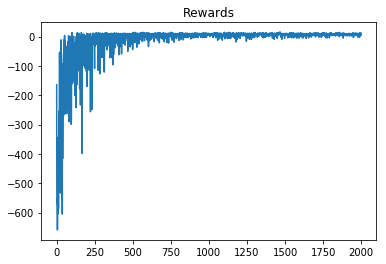

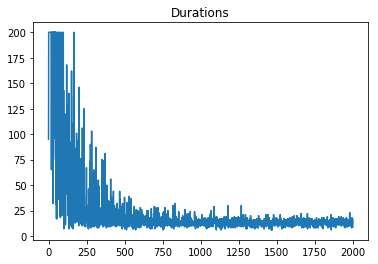

In [173]:
import gym

env = gym.make("Taxi-v2")

q_table = np.zeros((n_states, n_actions))  # Таблица для q-learning'a

LR = 0.8
EPS = 0.1
DISCOUNT = 0.99  # Ценность предыдущего значения таблицы
N_EPOCHS = 2000
PRINT_EACH = 100

all_rewards = []    # Наглады каждоый эпохи
all_durations = []  # Длительности каждой эпохи

for epoch in range(N_EPOCHS):
    local_reward = 0
    state = env.reset()

    for t in count():
        
        # Exploration-Exploitation Trade-off
        if np.random.rand() < EPS:
            action = env.action_space.sample()  # Exploration
        else:
            action = np.argmax(q_table[state])  # Exploitation - выбираю действие с
                                                # максимальной наградой
        
        next_state, reward, done, _ = env.step(action)  # Делаю шаг
        local_reward += reward
        if done:
            all_durations.append(t + 1)
            all_rewards.append(local_reward)
            EPS *= 0.999  # Уменьшаю вероятноть Exploration'a
            break

        # Обновляю `q_table`:          <....    Add reward to discounted max    ......>
        q_table[state, action] += LR * (reward + DISCOUNT * np.max(q_table[next_state]) - 
        #                              <....  Prev value  ....>
                                        q_table[state, action])

        state = next_state  # Update `state`
        
    if epoch % PRINT_EACH == 0:
        print('[Epoch {}] - Reward {}, Duration {}, EPS {}'.format(epoch, all_rewards[-1],
                                                                   all_durations[-1], EPS))
        
plt.plot(all_rewards)
plt.title('Rewards')
plt.show()

plt.plot(all_durations)
plt.title('Durations')
plt.show()